# IDM Engineering - March Madness Machine Learning - 2020

Welcome to the first IDM engineering March Madness Machine Learning lunch and learn! Thanks for attending!



## Table of Contents:
* Library Imports 
* Data Wrangling
* 

## Library Imports

Python is an incredibly flexible language, partially due to how modular it is. We can extend its basic functionality by importanting 3rd party libraries.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import seaborn as sns

import os
import pkg_resources

from binaryTree import Node
# import matplotlib.pyplot as plt # for notebook usage
# import numpy as np # for notebook usage
import pandas as pd
from PIL import Image, ImageDraw

# import slot_coordinates
import matplotlib.pyplot as plt


import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

In [2]:
cwd = os.getcwd()

## Data Manipulation

The intention of the data manipulation section is to create a dataframe of our target variable (result) and the given factors.

First, let's see what format the data is in that we currently have.

In [3]:
# import tournament results and filter to only years > target year. 
tourney_cresults = pd.read_csv(cwd + '/data/MNCAATourneyCompactResults.csv')
seeds = pd.read_csv(cwd + '/data/MNCAATourneySeeds.csv')
season_dresults = pd.read_csv(cwd +'/data/MRegularSeasonDetailedResults.csv')

Tourney results is the results of every tournament game. 

In [4]:
tourney_cresults.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985     136     1120      59     1345      58    N      0
2    1985     136     1207      68     1250      43    N      0
3    1985     136     1229      58     1425      55    N      0
4    1985     136     1242      49     1325      38    N      0

Seeds is the seed team ID for each season. 

In [5]:
seeds.head()

Season Seed  TeamID
0    1985  W01    1207
1    1985  W02    1210
2    1985  W03    1228
3    1985  W04    1260
4    1985  W05    1374

season_dresults is the regular season results, including every statistic that we have access to. 

In [6]:
season_dresults.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003      10     1104      68     1328      62    N      0    27    58   
1    2003      10     1272      70     1393      63    N      0    26    62   
2    2003      11     1266      73     1437      61    N      0    24    58   
3    2003      11     1296      56     1457      50    N      0    18    38   
4    2003      11     1400      77     1208      71    N      0    30    61   

   ...  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0  ...     10    16    22   10   22     8   18     9     2   20  
1  ...     24     9    20   20   25     7   12     8     6   16  
2  ...     26    14    23   31   22     9   12     2     5   23  
3  ...     22     8    15   17   20     9   19     4     3   23  
4  ...     16    17    27   21   15    12   10     7     1   14  

[5 rows x 34 columns]

If you are unfamiliar with what these statistics are, here is a quick description

Field descriptions:  
Seed: team's seeds  
WinPct: team's winning percentage 
PointsFor: average points scored per game  
PointsAgainst: average points scored agains the teams  
FGM: field goals made per game  
FGA: field goals attempted per game  
FGM3: 3 point fields goals made per game  
FGA3: fields goals attempted per game  
FTM: free throws made per game  
FTA: free throws attempted per game  
OR: offense rebounds per game  
DR: defensive rebounds per game  
Ast: assists per game  
TO: turnovers per game  
Stl: steals per game  
Blk: blocks per game  
PF: personal fouls per game  

A lot of data wrangling is to determine what information is useful. Here we need to establish what historical information to include in our model. For our purposes, we will include everything from 2003 and beyond. 

In [7]:
targetYear = 2003
tourney_cresults = tourney_cresults.loc[tourney_cresults['Season'] >= targetYear]

The first thing we are going to do is create a training set of data. Lets start with an empty dataframe.

Think of a dataframe as similar to an excel table. 

In [8]:
# create the training data set. Team 1 is winner, Team 2 is loser. 
training_set = pd.DataFrame()

Now, what are some things we want in our training set? What is our target variable? Result, so probably want that.  
How about Team 1, Team 2, and season as well. 

In [9]:
training_set['Result'] = np.random.randint(0,2,len(tourney_cresults.index))
training_set['Season'] = tourney_cresults['Season'].values
training_set['Team1'] = training_set['Result'].values * tourney_cresults['WTeamID'].values + (1-training_set['Result'].values) * tourney_cresults['LTeamID'].values 
training_set['Team2'] = (1-training_set['Result'].values) * tourney_cresults['WTeamID'].values + training_set['Result'].values * tourney_cresults['LTeamID'].values
training_set.head()

Result  Season  Team1  Team2
0       0    2003   1411   1421
1       1    2003   1112   1436
2       0    2003   1272   1113
3       0    2003   1166   1141
4       1    2003   1143   1301

So now we have a dataset of every team that played against each other, who the winner was.

What are some other pieces of information we would like in our training data? One of the most obvious things would be the difference in the seeds that year. 

First lets define some helper functions. Don't worry about how these work, this isn't a coding course!

In [10]:
seeds['Seed'] =  pd.to_numeric(seeds['Seed'].str[1:3], downcast='integer',errors='coerce')

def delta_seed(row):
    cond = (seeds['Season'] == row['Season'])
    return seeds[cond & (seeds['TeamID'] == row['Team1'])]['Seed'].iloc[0] - seeds[cond & (seeds['TeamID'] == row['Team2'])]['Seed'].iloc[0]

# function to, given a row, calculate what the difference between the two seeds was. 
#Function to look up 
def delta_winPct(row):
    cond1 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team1'])
    cond2 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team2'])
    return (record[cond1]['wins']/record[cond1]['games']).mean() - (record[cond2]['wins']/record[cond2]['games']).mean()

def get_points_against(row):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'LScore'
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'WScore'
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum() 
    return retVal

def get_points_for(row):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'WScore'
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'LScore'
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum() 
    return retVal

def get_remaining_stats(row, field):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'W' + field
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'L'+ field
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum()
    return retVal

def delta_stat(row, field):
    cond1 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team1'])
    cond2 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team2'])
    return (record[cond1][field]/record[cond1]['games']).mean() - (record[cond2][field]/record[cond2]['games']).mean()
  

Now, to add deltaSeed, we can just call our delta_seed function

In [11]:
#  Calculate Delta Seeds
training_set['deltaSeed'] = training_set.apply(delta_seed,axis=1)
training_set.head()

Result  Season  Team1  Team2  deltaSeed
0       0    2003   1411   1421          0
1       1    2003   1112   1436        -15
2       0    2003   1272   1113         -3
3       0    2003   1166   1141         -5
4       1    2003   1143   1301         -1

Next, lets add what the difference in the teams records are. That is usually a good indication of how good a team is! To do this, first lets build a dataframe of every teams wins, losses, and how many games they played. 

In [12]:
# Calculate win pct
record = pd.DataFrame({'wins': season_dresults.groupby(['Season','WTeamID']).size()}).reset_index();
losses = pd.DataFrame({'losses': season_dresults.groupby(['Season','LTeamID']).size()}).reset_index();

record = record.merge(losses, how='outer', left_on=['Season','WTeamID'], right_on=['Season','LTeamID'])
record = record.fillna(0)
record['games'] = record['wins'] + record['losses']

In [13]:
record.head()

Season  WTeamID  wins  LTeamID  losses  games
0    2003   1102.0  12.0   1102.0    16.0   28.0
1    2003   1103.0  13.0   1103.0    14.0   27.0
2    2003   1104.0  17.0   1104.0    11.0   28.0
3    2003   1105.0   7.0   1105.0    19.0   26.0
4    2003   1106.0  13.0   1106.0    15.0   28.0

Now, we can use our function to calculate the win percentage difference of the two teams that play each other and store it to the training_set dataframe. 

Now, in order to help calculate some of the next pieces of information, it is helpful to create a dataframe of both winners and losers. Don't worry about too much, just know that they are needed for our functions.

In [14]:
# create dataframes of both winners and losers
dfW = season_dresults.groupby(['Season','WTeamID']).sum().reset_index()
dfL = season_dresults.groupby(['Season','LTeamID']).sum().reset_index()

In [15]:
# add points for and points against data
record['PointsFor'] = record.apply(get_points_for, axis=1)
record['PointsAgainst'] = record.apply(get_points_against, axis=1)

In [16]:
record.head()

Season  WTeamID  wins  LTeamID  losses  games  PointsFor  PointsAgainst
0    2003   1102.0  12.0   1102.0    16.0   28.0       1603           1596
1    2003   1103.0  13.0   1103.0    14.0   27.0       2127           2110
2    2003   1104.0  17.0   1104.0    11.0   28.0       1940           1820
3    2003   1105.0   7.0   1105.0    19.0   26.0       1866           1993
4    2003   1106.0  13.0   1106.0    15.0   28.0       1781           1785

Lets go ahead and pull in all of the other stats into our records dataframe. We will make it a for loop to speed it up. - Cut to slides here

In [17]:
# This cell takes ~5 min
cols = ['FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols:
    print("Processing",col)
    record[col] = record.apply(get_remaining_stats, args=(col,), axis=1)

#record['FGprct'] = record['FGM'] / record['FGA']  

Processing FGM
Processing FGA
Processing FGM3
Processing FGA3
Processing FTM
Processing FTA
Processing OR
Processing DR
Processing Ast
Processing TO
Processing Stl
Processing Blk
Processing PF


In [18]:
record.head()

Season  WTeamID  wins  LTeamID  losses  games  PointsFor  PointsAgainst  \
0    2003   1102.0  12.0   1102.0    16.0   28.0       1603           1596   
1    2003   1103.0  13.0   1103.0    14.0   27.0       2127           2110   
2    2003   1104.0  17.0   1104.0    11.0   28.0       1940           1820   
3    2003   1105.0   7.0   1105.0    19.0   26.0       1866           1993   
4    2003   1106.0  13.0   1106.0    15.0   28.0       1781           1785   

   FGM   FGA  ...  FGA3  FTM  FTA   OR   DR  Ast   TO  Stl  Blk   PF  
0  536  1114  ...   583  312  479  117  471  364  320  167   50  525  
1  733  1508  ...   434  514  698  264  538  411  341  196   63  536  
2  673  1601  ...   556  416  586  380  670  339  372  185  106  505  
3  634  1602  ...   540  401  568  351  601  378  485  242   54  526  
4  656  1548  ...   494  298  461  344  668  327  477  234   88  509  

[5 rows x 21 columns]

In addition to extracting features from existing data, we could also create our own features by  performing calculations on the data! Let's do an easy one, field goal percentage. 

In [19]:
record['FGprct'] = record['FGM'] / record['FGA']  
record.head()

Season  WTeamID  wins  LTeamID  losses  games  PointsFor  PointsAgainst  \
0    2003   1102.0  12.0   1102.0    16.0   28.0       1603           1596   
1    2003   1103.0  13.0   1103.0    14.0   27.0       2127           2110   
2    2003   1104.0  17.0   1104.0    11.0   28.0       1940           1820   
3    2003   1105.0   7.0   1105.0    19.0   26.0       1866           1993   
4    2003   1106.0  13.0   1106.0    15.0   28.0       1781           1785   

   FGM   FGA  ...  FTM  FTA   OR   DR  Ast   TO  Stl  Blk   PF    FGprct  
0  536  1114  ...  312  479  117  471  364  320  167   50  525  0.481149  
1  733  1508  ...  514  698  264  538  411  341  196   63  536  0.486074  
2  673  1601  ...  416  586  380  670  339  372  185  106  505  0.420362  
3  634  1602  ...  401  568  351  601  378  485  242   54  526  0.395755  
4  656  1548  ...  298  461  344  668  327  477  234   88  509  0.423773  

[5 rows x 22 columns]

You can see we have succesfully added the column FGprct to our dataframe!

Now, to get all of this good data from records into a format for our training set. What is it we are really after? In reality, it would be really hard to tell who would win a game based off of just the raw data. But what WOULD be useful, is the difference in raw data between the two teams. 

To get this, we can run our helper function and put all of the results in the training set dataframe.

In [20]:
training_set.head()

Result  Season  Team1  Team2  deltaSeed
0       0    2003   1411   1421          0
1       1    2003   1112   1436        -15
2       0    2003   1272   1113         -3
3       0    2003   1166   1141         -5
4       1    2003   1143   1301         -1

In [21]:
cols = ['PointsFor','PointsAgainst','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols:
    print("Processing",col)
    training_set['delta' + col] = training_set.apply(delta_stat,args=(col,),axis=1)

Processing PointsFor
Processing PointsAgainst
Processing FGM
Processing FGA
Processing FGM3
Processing FGA3
Processing FTM
Processing FTA
Processing OR
Processing DR
Processing Ast
Processing TO
Processing Stl
Processing Blk
Processing PF


In [22]:
training_set['deltaWinPct'] = training_set.apply(delta_winPct,axis=1)

In [23]:
training_set.head()

Result  Season  Team1  Team2  deltaSeed  deltaPointsFor  \
0       0    2003   1411   1421          0        1.593103   
1       1    2003   1112   1436        -15       17.421182   
2       0    2003   1272   1113         -3       -1.448276   
3       0    2003   1166   1141         -5       -0.102403   
4       1    2003   1143   1301         -1        2.082759   

   deltaPointsAgainst  deltaFGM  deltaFGA  deltaFGM3  ...  deltaFTM  deltaFTA  \
0           -7.614943  0.354023 -1.526437  -0.549425  ...  1.434483  7.135632   
1            7.112069  5.493842  9.852217   1.759852  ...  4.673645  5.448276   
2           -3.344828 -0.931034  3.103448   3.000000  ... -2.586207 -3.310345   
3           -8.908046  2.076280  4.764890   1.142111  ... -5.397074 -5.142111   
4            1.758621  3.011494  5.390805  -1.552874  ... -2.387356 -0.949425   

    deltaOR   deltaDR  deltaAst   deltaTO  deltaStl  deltaBlk   deltaPF  \
0  0.890805  1.627586  1.165517 -0.973563 -0.635632 -0.766667 -0.803448   
1  2.213054  1.918719  3.435961  0.716749  1.602217  1.248768  1.853448   
2  0.379310  2.655172  1.068966 -0.206897  2.172414  0.827586 -0.655172   
3  0.292581 -0.094044  1.197492 -4.877743  1.290491  0.454545 -3.692790   
4  1.508046  2.345977  1.333333 -0.027586 -1.214943 -0.273563 -1.563218   

   deltaWinPct  
0     0.151724  
1     0.237685  
2     0.172414  
3     0.085684  
4     0.124138  

[5 rows x 21 columns]

Pandas has a ton of built in helper function to help make sense of your data. For instance, stats on all of our columns. 

In [24]:
training_set.describe()

Result       Season        Team1        Team2    deltaSeed  \
count  1115.00000  1115.000000  1115.000000  1115.000000  1115.000000   
mean      0.50583  2011.096861  1298.207175  1291.626906    -0.313004   
std       0.50019     4.896921   102.403991   105.912072     7.457947   
min       0.00000  2003.000000  1103.000000  1101.000000   -15.000000   
25%       0.00000  2007.000000  1211.000000  1210.000000    -7.000000   
50%       1.00000  2011.000000  1297.000000  1277.000000     0.000000   
75%       1.00000  2015.000000  1393.000000  1393.000000     5.000000   
max       1.00000  2019.000000  1463.000000  1463.000000    15.000000   

       deltaPointsFor  deltaPointsAgainst     deltaFGM     deltaFGA  \
count     1115.000000         1115.000000  1115.000000  1115.000000   
mean         0.179973           -0.155774     0.095295     0.253157   
std          7.291600            6.406735     2.913354     4.872352   
min        -21.643382          -19.145650    -8.602941   -17.404412   
25%         -4.649454           -4.521556    -1.936822    -3.030777   
50%          0.055147           -0.102496     0.065954     0.421569   
75%          4.972601            4.097665     2.073986     3.457823   
max         22.892857           25.035714     9.357143    22.071429   

         deltaFGM3  ...     deltaFTM     deltaFTA      deltaOR      deltaDR  \
count  1115.000000  ...  1115.000000  1115.000000  1115.000000  1115.000000   
mean     -0.019237  ...     0.008620     0.056672     0.134574     0.018294   
std       1.804896  ...     2.708524     3.659169     2.559085     2.563982   
min      -6.007315  ...    -7.246334   -10.827586    -7.924632    -9.010776   
25%      -1.193672  ...    -1.880789    -2.305704    -1.559978    -1.705390   
50%       0.042614  ...     0.069260    -0.051515     0.151515    -0.043672   
75%       1.187500  ...     1.806452     2.458898     1.833333     1.647001   
max       6.062500  ...     8.059629    10.772059     9.214286     9.285714   

          deltaAst      deltaTO     deltaStl     deltaBlk      deltaPF  \
count  1115.000000  1115.000000  1115.000000  1115.000000  1115.000000   
mean      0.051769    -0.072231     0.082206     0.039138     0.027364   
std       2.597673     2.069103     1.850168     1.855687     2.533186   
min      -8.363636    -7.448276    -6.283681    -5.860606    -7.896552   
25%      -1.720952    -1.404189    -1.094920    -1.156630    -1.688419   
50%      -0.062500    -0.031250    -0.003676     0.029412     0.028520   
75%       1.786121     1.277609     1.314304     1.175901     1.827986   
max       9.220143     7.666667     6.089015     6.752688     7.256303   

       deltaWinPct  
count  1115.000000  
mean      0.006902  
std       0.144330  
min      -0.633333  
25%      -0.088057  
50%       0.000000  
75%       0.097422  
max       0.515152  

[8 rows x 21 columns]

We are in really good shape at this point to start exploring our data in the next section!

In [25]:
training_set.to_csv("training_set.csv", index=False)

In [26]:
training_set = pd.read_csv("training_set.csv")

## Data Analysis

This is where the bulk of the work in machine learning takes place. As you can see, it can be very time consuming to get data into a presentable format. Where the real magic happens is determining what to do with that data once you have it. 

There are several libraries that we will explore to help see the relationships between your data. It is very important to get a good sense of how your features are related to the result before you try to build a model. 

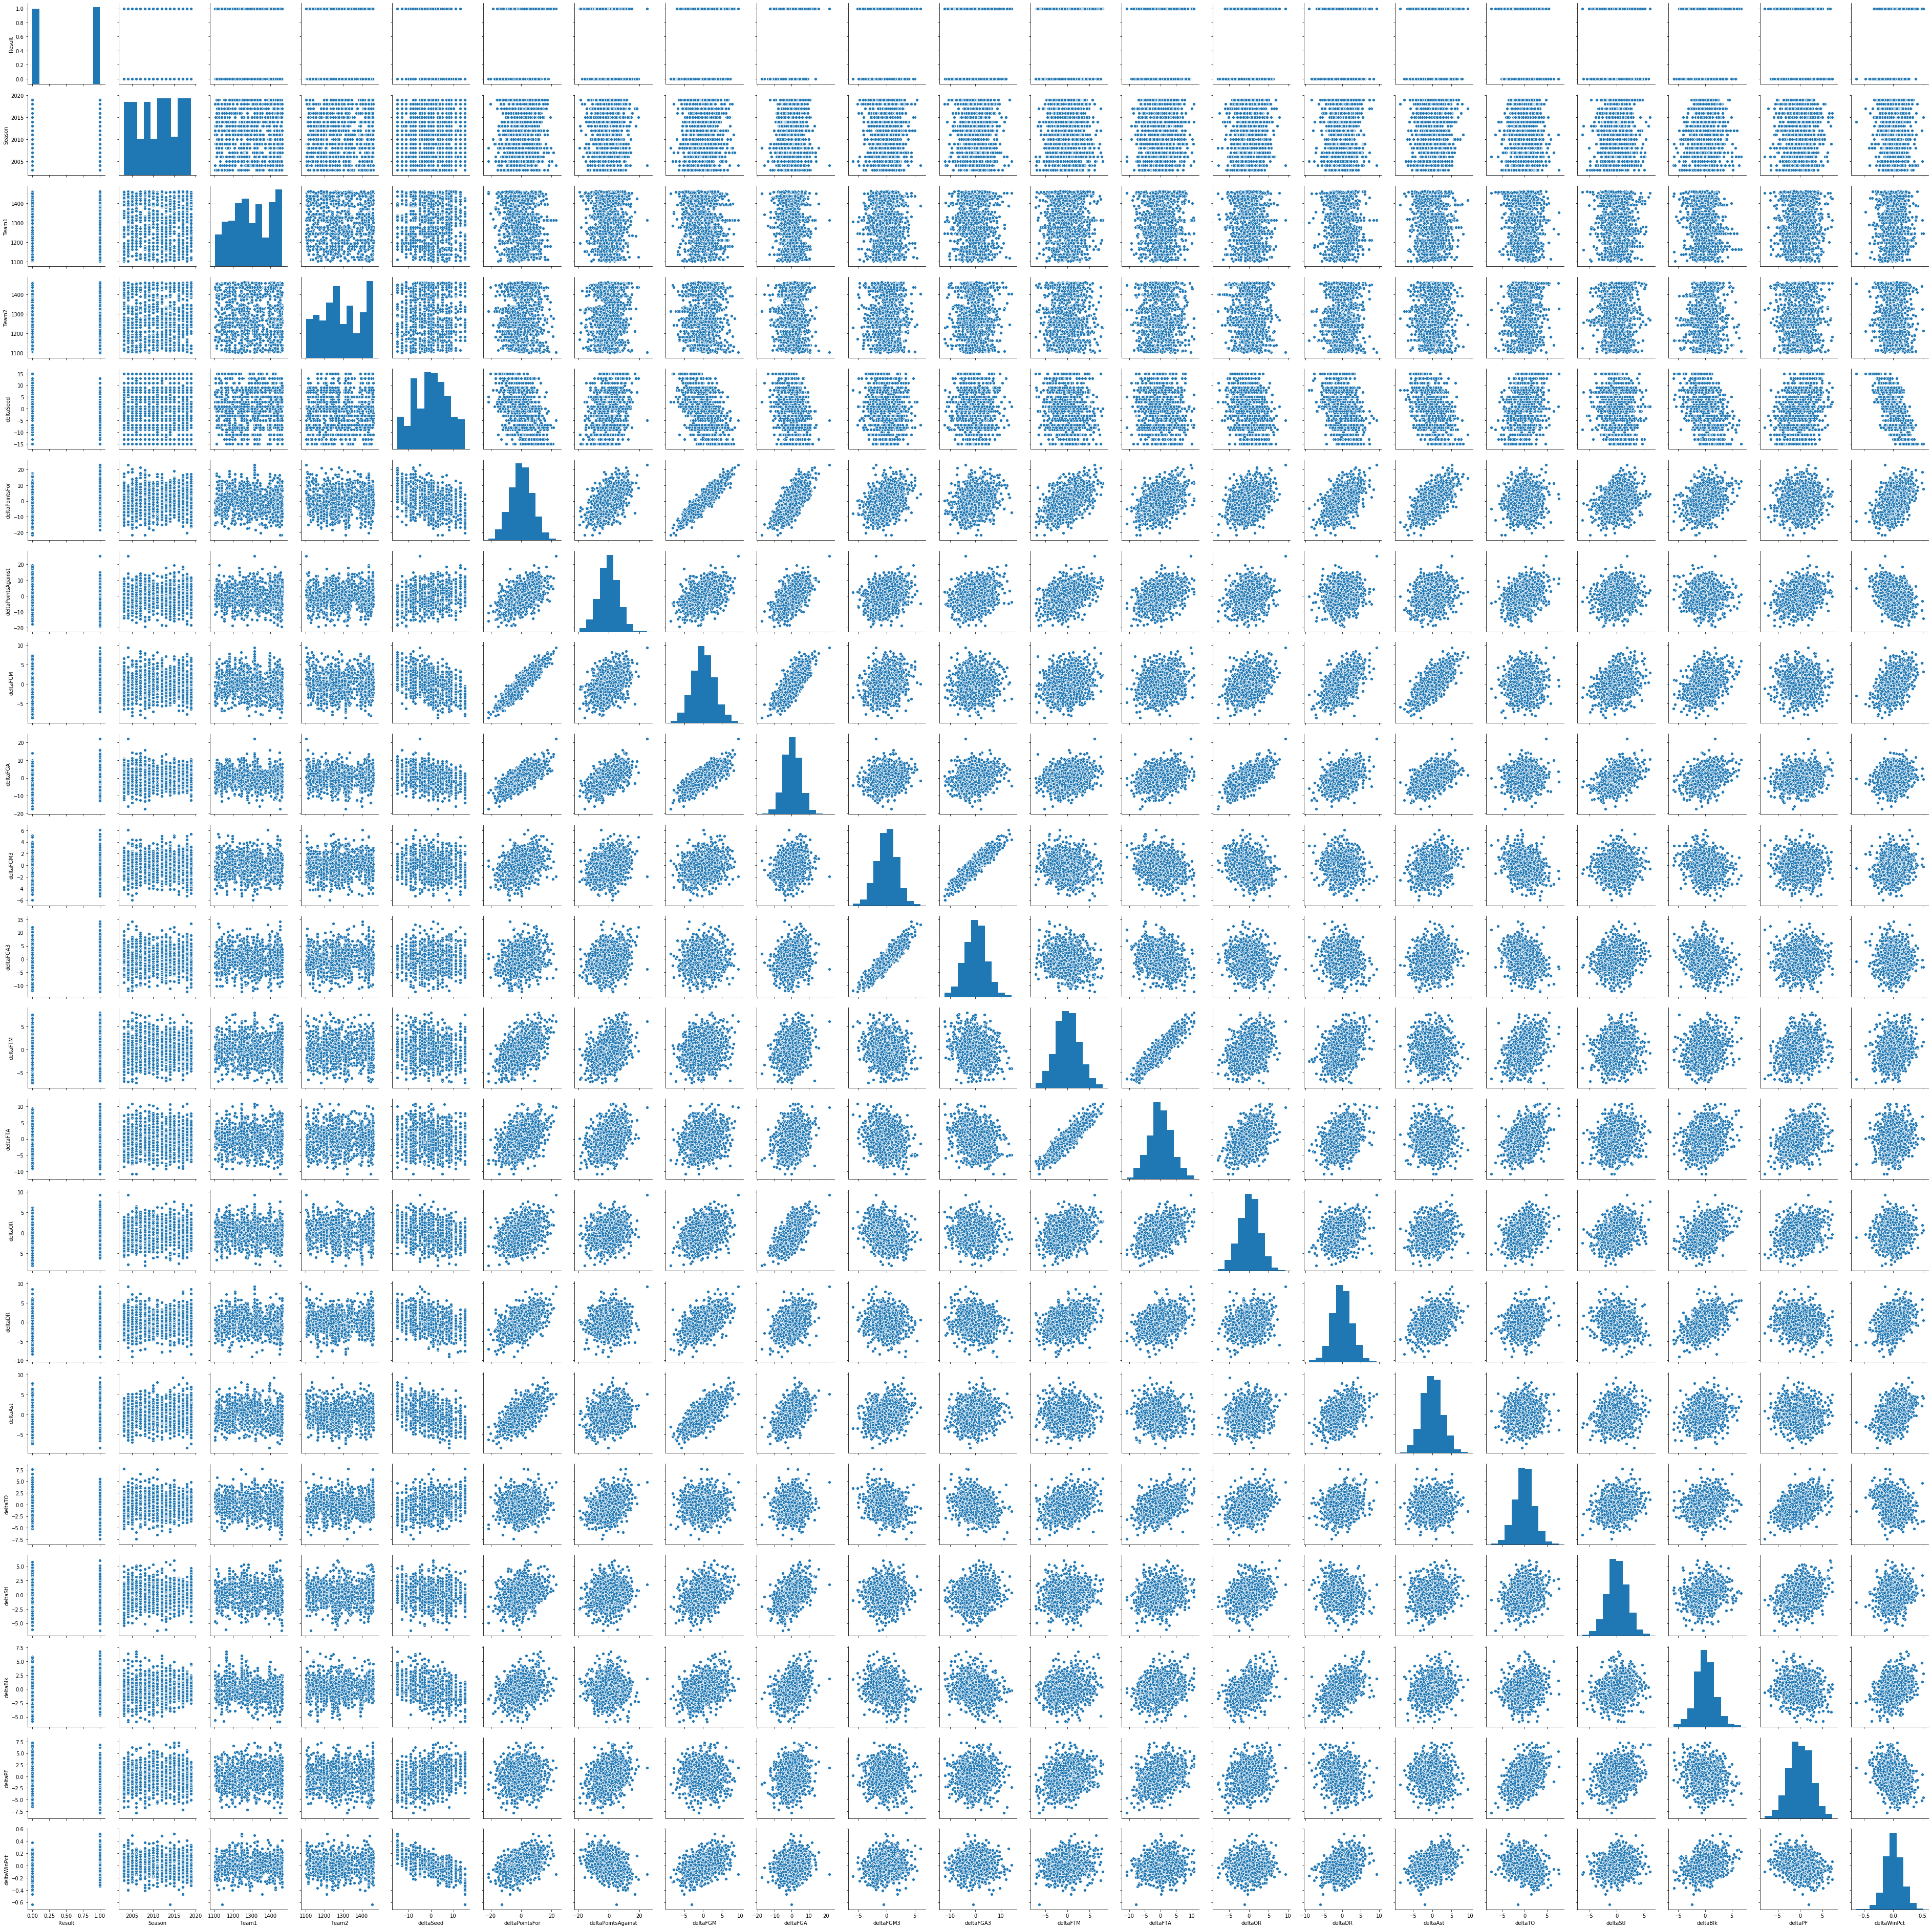

In [27]:
sns.pairplot(data = training_set)

Whew..... thats a lot of data. We have some work to do. 

A very simple tool I like to use to get started is the correlation tool. This lets you see which data is correlated with each other. 

In [28]:
correlation = training_set.corr()

So what did we just do? Well, if we graph a heatmap, you can see that we were able to determine how all variables are linearly related to each other, and visually quickly undertand this relationship. 

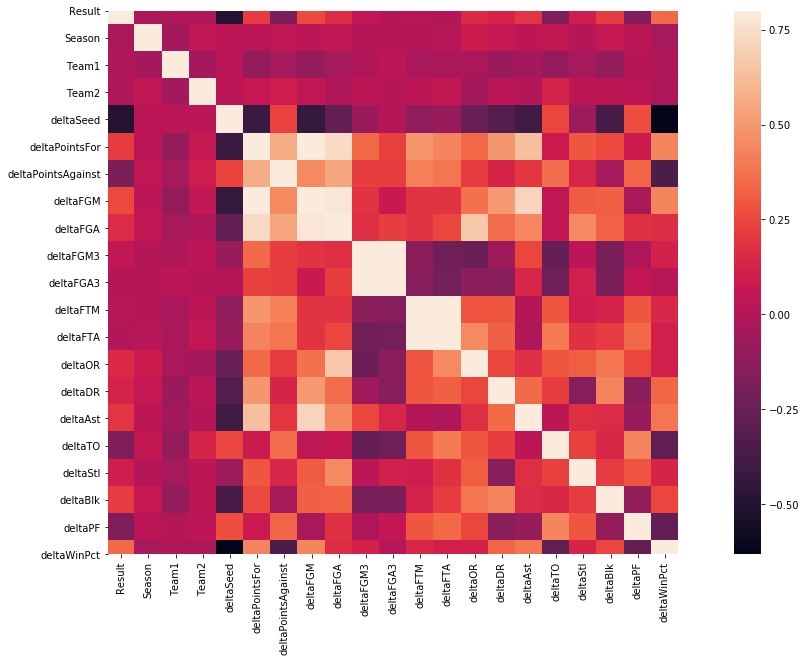

In [29]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.heatmap(correlation, vmax=.8, square=True)

What are some things we notice about this plot? Does it make sense? 

One thing that I think is interesting is the strong relationship between assists, and field goals made. 

The obvious ones are the relationship between field goals made and field goals attempted. 

At no point in this process should you be blindly developing a model. Taking a second to check if your results are rational goes a long way. 

Although this is nice, in reality, we are really only interested in one thing here... RESULTS!

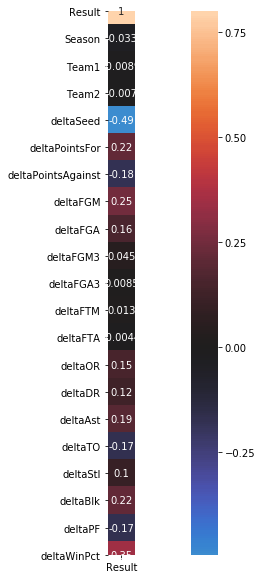

In [30]:
sns.heatmap(correlation[["Result"]], vmax=.8, square=True, center=0, annot=True)

Here you can see that there is not a strong correlation between any of our features and result. It's almost as if this were a difficult machine learning problem with no clear indicator!

## Model Creation

Here we go, the moment you have all been waiting for. Model creation! 

First thing we are going to do is consider define an X and a y. This should look a lot like a simple linear equation, X being an array of Xs. 

In [31]:
training_set.head()

Result  Season  Team1  Team2  deltaSeed  deltaPointsFor  \
0       0    2003   1411   1421          0        1.593103   
1       1    2003   1112   1436        -15       17.421182   
2       0    2003   1272   1113         -3       -1.448276   
3       0    2003   1166   1141         -5       -0.102403   
4       1    2003   1143   1301         -1        2.082759   

   deltaPointsAgainst  deltaFGM  deltaFGA  deltaFGM3  ...  deltaFTM  deltaFTA  \
0           -7.614943  0.354023 -1.526437  -0.549425  ...  1.434483  7.135632   
1            7.112069  5.493842  9.852217   1.759852  ...  4.673645  5.448276   
2           -3.344828 -0.931034  3.103448   3.000000  ... -2.586207 -3.310345   
3           -8.908046  2.076280  4.764890   1.142111  ... -5.397074 -5.142111   
4            1.758621  3.011494  5.390805  -1.552874  ... -2.387356 -0.949425   

    deltaOR   deltaDR  deltaAst   deltaTO  deltaStl  deltaBlk   deltaPF  \
0  0.890805  1.627586  1.165517 -0.973563 -0.635632 -0.766667 -0.803448   
1  2.213054  1.918719  3.435961  0.716749  1.602217  1.248768  1.853448   
2  0.379310  2.655172  1.068966 -0.206897  2.172414  0.827586 -0.655172   
3  0.292581 -0.094044  1.197492 -4.877743  1.290491  0.454545 -3.692790   
4  1.508046  2.345977  1.333333 -0.027586 -1.214943 -0.273563 -1.563218   

   deltaWinPct  
0     0.151724  
1     0.237685  
2     0.172414  
3     0.085684  
4     0.124138  

[5 rows x 21 columns]

In [32]:
# cols = ['deltaSeed', 'deltaWinPct','deltaPointsFor','deltaPointsAgainst','deltaFGM','deltaFGA','deltaFGM3','deltaFGA3','deltaFTM',
#         'deltaFTA','deltaOR','deltaDR','deltaAst','deltaTO','deltaStl','deltaBlk','deltaPF']
cols = ['deltaSeed', 'deltaSeed', 'deltaPointsFor', 'deltaFGM', 'deltaAst']
X = training_set[cols]
y = training_set['Result']   

## Linear - Ordinary Least Squares

Lets start off with something that everyone is probably familiar with. Ordinary Least Squares

In [106]:
from sklearn import linear_model

We start by creating an instance of a LinearRegression object. 

In [107]:
linearModel = linear_model.LinearRegression()

Then we can fit our X, y data to the object to train the model.

In [108]:
linearModel.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Once the model has been fitted, you can score it as well with the .score() method!

In [109]:
linearModel.score(X,y)

0.249987460840577

And we can make predictions by passing our X values to the .predict() method.

In [112]:
linearModel.predict(X)

array([0.47920358, 0.97966602, 0.55896967, ..., 0.47457616, 0.63438625,
       0.44319815])

In [38]:
year = 2018
X_test = training_set[training_set['Season'] == year][cols]
y_test = training_set[training_set['Season'] == year]['Result']

This array of values represents the probability that team 1 will beat team 2 in our X dataframe. Let's take a look at how this model does in year 2018

In [39]:
year = 2018
X_test = training_set[training_set['Season'] == year][cols]
y_test = training_set[training_set['Season'] == year]['Result']

df_results = X_test
df_results['Prediction'] = linearModel.predict(X_test)
df_results['Result'] = y_test
df_results

deltaSeed  deltaSeed  deltaPointsFor  deltaFGM  deltaAst  Prediction  \
981           0          0        9.759470  3.294508  0.458333    0.519620   
982           0          0       -4.000000 -1.937500 -0.843750    0.471932   
983           0          0       15.970674  5.210166  3.191593    0.499952   
984           0          0        7.259962 -0.337761 -2.574004    0.452045   
985           1          1       -7.365809 -2.862132 -3.970588    0.473947   
...         ...        ...             ...       ...       ...         ...   
1043          1          1        3.196970  0.427807  0.515152    0.443564   
1044         -2         -2       11.816399  4.877897  2.252228    0.599858   
1045         -8         -8        1.959559  0.647059 -0.849265    0.769206   
1046          0          0       -5.558824 -0.911765  0.323529    0.506562   
1047          2          2      -13.411765 -4.382353 -2.088235    0.417998   

      Result  
981        0  
982        1  
983        0  
984        1  
985        1  
...      ...  
1043       0  
1044       1  
1045       1  
1046       0  
1047       0  

[67 rows x 7 columns]

It definitely gets SOME of them right? I think? Let's see how it does over all years. 

In [40]:
for year in range(2003,2019):
    X_test = training_set[training_set['Season'] == year][cols]
    y_test = training_set[training_set['Season'] == year]['Result']

    df_results = X_test
    df_results['Prediction'] = linearModel.predict(X_test)
    df_results['Result'] = y_test
    df_results
    
    correct = df_results.loc[(df_results['Result']==0) & (df_results['Prediction']<0.5)].shape[0]
    correct = correct + df_results.loc[(df_results['Result']==1) & (df_results['Prediction']>0.5)].shape[0]

    total = df_results.shape[0]

    accuracy = correct/total

    error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
    print("Year:", year, "Accuracy:", accuracy, "Error:", error, )

Year: 2003 Accuracy: 0.703125 Error: 0.518394809847582
Year: 2004 Accuracy: 0.765625 Error: 0.5269818080890785
Year: 2005 Accuracy: 0.703125 Error: 0.56054196143636
Year: 2006 Accuracy: 0.65625 Error: 0.6612016520222237
Year: 2007 Accuracy: 0.796875 Error: 0.4709485865848946
Year: 2008 Accuracy: 0.78125 Error: 0.5026630495943913
Year: 2009 Accuracy: 0.75 Error: 0.5338515016328906
Year: 2010 Accuracy: 0.65625 Error: 0.48984274321337845
Year: 2011 Accuracy: 0.6716417910447762 Error: 0.5794803166327197
Year: 2012 Accuracy: 0.6417910447761194 Error: 0.5551552786368256
Year: 2013 Accuracy: 0.7014925373134329 Error: 0.6165425401116862
Year: 2014 Accuracy: 0.6567164179104478 Error: 0.5969534912632598
Year: 2015 Accuracy: 0.8059701492537313 Error: 0.47598442131408963
Year: 2016 Accuracy: 0.6417910447761194 Error: 0.6368412001201568
Year: 2017 Accuracy: 0.7313432835820896 Error: 0.5164254630499912
Year: 2018 Accuracy: 0.6716417910447762 Error: 0.5662219121743449


C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Remember, 50% is considered random, so this model is..... not great. Let's see if we can do better.

## Linear - Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

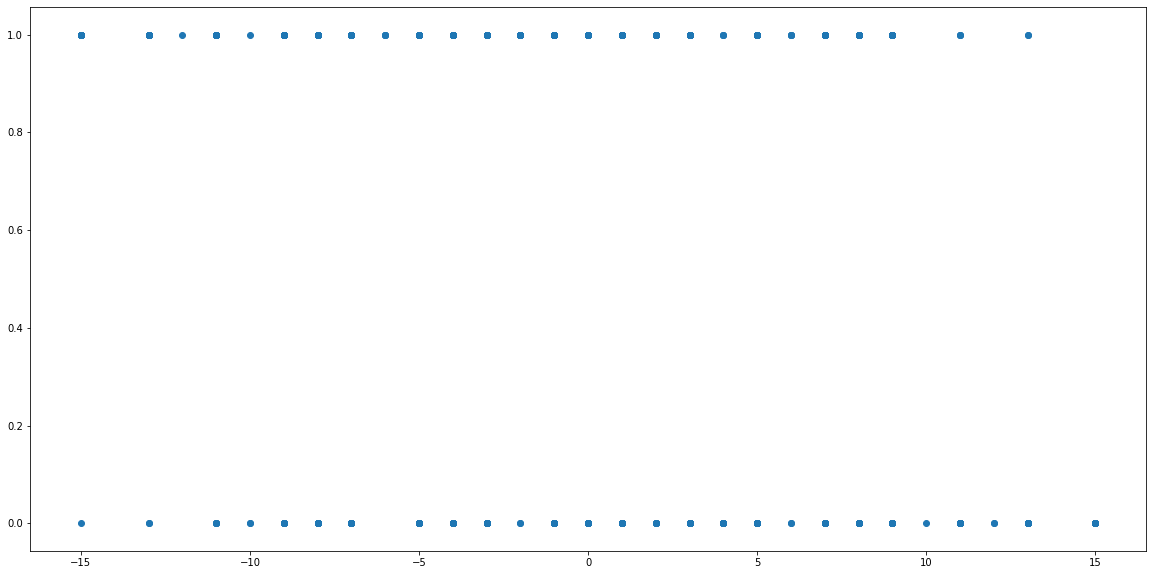

In [42]:
plt.scatter(training_set['deltaSeed'],training_set['Result'])

In [43]:
logisticModel = linear_model.LogisticRegression(solver='lbfgs')
logisticModel.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
logisticModel.score(X,y)

0.705829596412556

In [45]:
for year in range(2003,2019):
    X_test = training_set[training_set['Season'] == year][cols]
    y_test = training_set[training_set['Season'] == year]['Result']

    df_results = X_test
    df_results['Prediction'] = logisticModel.predict_proba(X_test)[:,1]
    df_results['Result'] = y_test
    df_results

    correct = df_results.loc[(df_results['Result']==0) & (df_results['Prediction']<0.5)].shape[0]
    correct = correct + df_results.loc[(df_results['Result']==1) & (df_results['Prediction']>0.5)].shape[0]

    total = df_results.shape[0]

    accuracy = correct/total

    df_results.loc[df_results['Prediction'] > 0.9, 'Prediction']=0.99
    df_results.loc[df_results['Prediction'] < 0.1, 'Prediction']=0.01

    error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
    print("Year:", year, ","," Error:", error, "Accuracy:", accuracy)

Year: 2003 ,  Error: 0.5135943457072819 Accuracy: 0.703125
Year: 2004 ,  Error: 0.5376907726502159 Accuracy: 0.765625
Year: 2005 ,  Error: 0.5562383944212472 Accuracy: 0.703125
Year: 2006 ,  Error: 0.6744168326877207 Accuracy: 0.65625
Year: 2007 ,  Error: 0.4649582884614173 Accuracy: 0.796875
Year: 2008 ,  Error: 0.5012453089721092 Accuracy: 0.78125
Year: 2009 ,  Error: 0.5369148963902279 Accuracy: 0.75
Year: 2010 ,  Error: 0.49560982429151795 Accuracy: 0.65625
Year: 2011 ,  Error: 0.5807672367404577 Accuracy: 0.6716417910447762
Year: 2012 ,  Error: 0.545379149373776 Accuracy: 0.6417910447761194
Year: 2013 ,  Error: 0.6250163666091633 Accuracy: 0.7014925373134329
Year: 2014 ,  Error: 0.600650530481227 Accuracy: 0.6567164179104478
Year: 2015 ,  Error: 0.46356858625744785 Accuracy: 0.8059701492537313
Year: 2016 ,  Error: 0.6420407568844513 Accuracy: 0.6417910447761194
Year: 2017 ,  Error: 0.5238174983251875 Accuracy: 0.7164179104477612
Year: 2018 ,  Error: 0.6952494271837296 Accuracy: 0.

## Random Forest Classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
RFClassifier = RandomForestClassifier(n_estimators = 10)

In [48]:
RFClassifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
RFClassifier.score(X, y)

0.9811659192825112

Would you look at that! Pack up, lunch and learn over, we have found a model that is almost 100% Accurate!

Seem too good to be true? Then it probably is.

But why?

What is happening is that we are building a perfect model that is overspecifies. If you score based on your training data, your model will be incredibly biased. 

We have access to a couple of libraries that help with this. We are currently already doing this by testing per year, but in case you have data that is not manually seperable by something such as year, its still very important to 


In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

In [51]:
RFClassifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
RFClassifier.score(X_train, y_train)

0.9880358923230309

Now lets try scoring our testing data. 

In [53]:
RFClassifier.score(X_test, y_test)

0.5535714285714286

In [54]:
year = 2012
X_test = training_set[training_set['Season'] == year][cols]
y_test = training_set[training_set['Season'] == year]['Result']

#not sure if this should be :,1 or :,0
df_results = X_test
df_results['Prediction'] = RFClassifier.predict_proba(X_test)[:,1]
df_results['Result'] = y_test
df_results

df_results.loc[df_results['Prediction'] > 0.9, 'Prediction']=0.99
df_results.loc[df_results['Prediction'] < 0.1, 'Prediction']=0.01

correct = df_results.loc[(df_results['Result']==0) & (df_results['Prediction']<0.5)].shape[0]
correct = correct + df_results.loc[(df_results['Result']==1) & (df_results['Prediction']>0.5)].shape[0]

total = df_results.shape[0]

accuracy = correct/total

error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
print("Year:", year, ","," Error:", error, "Accuracy:", accuracy)

Year: 2012 ,  Error: 0.19521830784131913 Accuracy: 0.9402985074626866


In [55]:
df_results.head(50)

deltaSeed  deltaSeed  deltaPointsFor  deltaFGM  deltaAst  Prediction  \
579          0          0       -4.895161 -2.969758 -2.311492        0.50   
580          0          0       -3.848485 -1.969697 -2.242424        0.90   
581          0          0       12.854167  5.236742  4.435606        0.01   
582          0          0        5.389706  1.904412 -0.827206        0.10   
583        -11        -11       -2.102273  0.122159  0.821023        0.99   
584          5          5       -9.656250 -4.000000 -6.187500        0.90   
585          3          3       -2.342742  0.752016  0.851815        0.70   
586         -9         -9       -0.121212 -0.515152 -0.454545        0.70   
587          1          1       -4.339015  0.488636 -0.987689        0.10   
588         -1         -1        0.677419  1.129032  3.709677        0.80   
589        -15        -15       11.615865  5.353832  2.174688        0.99   
590          9          9        8.526267  2.255300 -0.223041        0.10   
591        -11        -11       -2.417339 -1.467742 -0.188508        0.99   
592         -5         -5        3.182028  0.513825  0.213134        0.80   
593          7          7        1.211694  0.736895 -1.964718        0.01   
594        -13        -13        7.170956  4.588235  2.970588        0.99   
595         15         15        3.957576 -1.809091 -0.518182        0.01   
596          7          7       -8.520873 -4.181214 -2.313093        0.70   
597          7          7       -7.842799 -2.671400  0.043611        0.20   
598         -9         -9       -7.362591 -2.706374 -2.160920        0.99   
599          5          5        4.560606 -0.331551 -0.606952        0.20   
600          1          1      -15.092803 -4.405303 -5.627841        0.20   
601         -3         -3       13.208211  3.746823  2.677419        0.90   
602         11         11        0.344086 -1.175953  1.594330        0.10   
603         11         11       12.960606  3.675758  3.833333        0.01   
604         13         13       -4.151515 -2.363636 -3.030303        0.01   
605         13         13       -1.890152 -0.007576  0.545455        0.80   
606        -15        -15       -9.731729 -1.300357  0.475045        0.90   
607          5          5        3.253321  1.482922  3.648008        0.80   
608        -13        -13       10.731618  3.687500  4.205882        0.20   
609        -15        -15       14.735294  6.529412  4.176471        0.90   
610         -9         -9       -3.462121 -0.488636 -0.189394        0.10   
611          3          3       -1.618182  0.078788 -1.703030        0.80   
612         -7         -7       17.219758  6.102823  3.987903        0.30   
613          1          1       -6.197343 -2.565465 -0.764706        0.90   
614         -3         -3       -4.303030 -2.212121  1.090909        0.40   
615         -8         -8        7.991477  3.372159  3.352273        0.90   
616          8          8       -8.890374 -2.763815 -1.188948        0.10   
617         -7         -7        3.488971  2.448529 -1.358456        0.60   
618          1          1        3.733929  0.615179  2.322321        0.40   
619         -3         -3        1.723214  1.857143  4.308036        0.80   
620          5          5       -0.796964 -2.652751 -1.228653        0.01   
621          7          7       -3.156403 -2.737048 -1.366569        0.20   
622          1          1        9.032977  2.584670  1.186275        0.60   
623          3          3       -1.833333 -0.213904  0.758467        0.70   
624         -8         -8        6.710227  2.111742  3.000000        0.99   
625          8          8       -2.848485 -1.121212 -1.909091        0.01   
626          8          8       -3.050285 -1.653700 -1.323529        0.01   
627         -8         -8       -4.949020 -2.443137 -2.470588        0.01   
628         -7         -7        1.940285  1.969697 -0.467914        0.90   

     Result  
579       1  
580       1  
581       0  
582       0  
583    

That looks much more realistic. Lets see how this one does over the years. 

In [56]:
for year in range(2003,2019):
    X_test = training_set[training_set['Season'] == year][cols]
    y_test = training_set[training_set['Season'] == year]['Result']

    #not sure if this should be :,1 or :,0
    df_results = X_test
    df_results['Prediction'] = RFClassifier.predict_proba(X_test)[:,1]
    df_results['Result'] = y_test
    df_results
    
    df_results.loc[df_results['Prediction'] > 0.9, 'Prediction']=0.99
    df_results.loc[df_results['Prediction'] < 0.1, 'Prediction']=0.01
    
    correct = df_results.loc[(df_results['Result']==0) & (df_results['Prediction']<0.5)].shape[0]
    correct = correct + df_results.loc[(df_results['Result']==1) & (df_results['Prediction']>0.5)].shape[0]

    total = df_results.shape[0]

    accuracy = correct/total

    error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
    print("Year:", year, ","," Error:", error, "Accuracy:", accuracy)

Year: 2003 ,  Error: 0.17506541169358011 Accuracy: 0.984375
Year: 2004 ,  Error: 0.2089554484289531 Accuracy: 0.96875
Year: 2005 ,  Error: 0.1738620142772031 Accuracy: 0.921875
Year: 2006 ,  Error: 0.2281982349389318 Accuracy: 0.9375
Year: 2007 ,  Error: 0.1652479705402233 Accuracy: 0.9375
Year: 2008 ,  Error: 0.1649243352631079 Accuracy: 0.9375
Year: 2009 ,  Error: 0.31717960552297475 Accuracy: 0.890625
Year: 2010 ,  Error: 0.19358279821590774 Accuracy: 0.953125
Year: 2011 ,  Error: 0.27527597314327307 Accuracy: 0.8955223880597015
Year: 2012 ,  Error: 0.19521830784131913 Accuracy: 0.9402985074626866
Year: 2013 ,  Error: 0.2575165728667813 Accuracy: 0.8955223880597015
Year: 2014 ,  Error: 0.18052552618063566 Accuracy: 0.9104477611940298
Year: 2015 ,  Error: 0.22383986918549093 Accuracy: 0.9104477611940298
Year: 2016 ,  Error: 0.24490499620527817 Accuracy: 0.9402985074626866
Year: 2017 ,  Error: 0.20579690290537653 Accuracy: 0.9402985074626866
Year: 2018 ,  Error: 0.19883120441452415 Ac

## Neural Network

In [57]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

In [59]:
NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,2), random_state=1)

In [60]:
NeuralNetwork.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [61]:
NeuralNetwork.score(X_test, y_test)

0.75

Not great.

One thing we can help is scale the data. Remember, neural networks are inherently dumb, so if you can feed it data that has been pre-processed, it will result in a much more accurate result

In [62]:
scaler = StandardScaler()

In [63]:
X_train

deltaSeed  deltaSeed  deltaPointsFor  deltaFGM  deltaAst
327           9          9       -5.271889 -3.376037 -2.527189
737          11         11      -10.652981 -5.369501 -4.448680
499          11         11       -4.062880 -1.241379  1.535497
1019         -7         -7        2.500000  1.555147  1.187500
778           6          6        2.366310  0.964349 -0.621212
...         ...        ...             ...       ...       ...
585           3          3       -2.342742  0.752016  0.851815
95            5          5       -4.102083 -1.483333 -1.243750
279           1          1       -8.560417 -2.781250 -2.450000
691          -8         -8       -4.077083 -1.952083 -1.685417
1100         -3         -3       13.936720  6.328877  5.329768

[1003 rows x 5 columns]

In [64]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_train

array([[ 1.27867511,  1.27867511, -0.75329321, -1.19546159, -1.01285507],
       [ 1.54859221,  1.54859221, -1.48939733, -1.87900478, -1.75599081],
       [ 1.54859221,  1.54859221, -0.58790735, -0.46350446,  0.55838644],
       ...,
       [ 0.19900668,  0.19900668, -1.20314586, -0.99151389, -0.98300229],
       [-1.0156203 , -1.0156203 , -0.58985024, -0.70719922, -0.68730011],
       [-0.34082753, -0.34082753,  1.8743401 ,  2.13227634,  2.02581876]])

In [65]:
NeuralNetwork.fit(X_train, y_train)
NeuralNetwork.score(X_test, y_test)

0.6875

In [66]:
for year in range(2003,2019):
    X_test = training_set[training_set['Season'] == year][cols]
    y_test = training_set[training_set['Season'] == year]['Result']

    #not sure if this should be :,1 or :,0
    df_results = X_test
    df_results['Prediction'] = NeuralNetwork.predict_proba(X_test)[:,1]
    df_results['Result'] = y_test
    df_results
    
    df_results.loc[df_results['Prediction'] > 0.9, 'Prediction']=0.99
    df_results.loc[df_results['Prediction'] < 0.1, 'Prediction']=0.01
    
    correct = df_results.loc[(df_results['Result']==0) & (df_results['Prediction']<0.5)].shape[0]
    correct = correct + df_results.loc[(df_results['Result']==1) & (df_results['Prediction']>0.5)].shape[0]

    total = df_results.shape[0]

    accuracy = correct/total

    error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
    print("Year:", year, ","," Error:", error, "Accuracy:", accuracy)

Year: 2003 ,  Error: 1.3853239619929265 Accuracy: 0.71875
Year: 2004 ,  Error: 1.5463675444858551 Accuracy: 0.734375
Year: 2005 ,  Error: 1.1273599486282755 Accuracy: 0.671875
Year: 2006 ,  Error: 1.8470647844445385 Accuracy: 0.671875
Year: 2007 ,  Error: 1.71439935101112 Accuracy: 0.765625
Year: 2008 ,  Error: 1.9156555399483677 Accuracy: 0.671875
Year: 2009 ,  Error: 1.5727486703042866 Accuracy: 0.765625
Year: 2010 ,  Error: 1.1690406152547395 Accuracy: 0.671875
Year: 2011 ,  Error: 1.912258973897997 Accuracy: 0.5970149253731343
Year: 2012 ,  Error: 1.6369964413214335 Accuracy: 0.6417910447761194
Year: 2013 ,  Error: 1.9959929061826673 Accuracy: 0.6119402985074627
Year: 2014 ,  Error: 2.0775061172213305 Accuracy: 0.582089552238806
Year: 2015 ,  Error: 1.2000760921892477 Accuracy: 0.7761194029850746
Year: 2016 ,  Error: 1.8178050490372606 Accuracy: 0.6268656716417911
Year: 2017 ,  Error: 1.5125740338451192 Accuracy: 0.7164179104477612
Year: 2018 ,  Error: 2.3977276333610176 Accuracy: 

## Grid Search CV

In [67]:
from sklearn.model_selection import GridSearchCV

In [68]:
parameters = {'solver': ['lbfgs'], 'max_iter': [1000,1500,2000 ], 'alpha': 10.0 ** -np.arange(1, 10, 5), 'hidden_layer_sizes':np.arange(1, 20, 5)}

In [69]:
OptimalNeuralNetwork = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

In [70]:
OptimalNeuralNetwork.fit(X_train, y_train)

C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.e-01, 1.e-06]),
    

In [71]:
OptimalNeuralNetwork.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': 1, 'max_iter': 1500, 'solver': 'lbfgs'}

In [72]:
for year in range(2003,2019):
    X_test = training_set[training_set['Season'] == year][cols]
    y_test = training_set[training_set['Season'] == year]['Result']

    #not sure if this should be :,1 or :,0
    df_results = X_test
    df_results['Prediction'] = OptimalNeuralNetwork.predict_proba(X_test)[:,1]
    df_results['Result'] = y_test
    df_results
    
    df_results.loc[df_results['Prediction'] > 0.9, 'Prediction']=0.99
    df_results.loc[df_results['Prediction'] < 0.1, 'Prediction']=0.01
    
    correct = df_results.loc[(df_results['Result']==0) & (df_results['Prediction']<0.5)].shape[0]
    correct = correct + df_results.loc[(df_results['Result']==1) & (df_results['Prediction']>0.5)].shape[0]

    total = df_results.shape[0]

    accuracy = correct/total

    error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
    print("Year:", year, ","," Error:", error, "Accuracy:", accuracy)

Year: 2003 ,  Error: 1.5840817364438962 Accuracy: 0.671875
Year: 2004 ,  Error: 1.4099385685244696 Accuracy: 0.734375
Year: 2005 ,  Error: 1.3126560468492106 Accuracy: 0.671875
Year: 2006 ,  Error: 1.8531260119966508 Accuracy: 0.65625
Year: 2007 ,  Error: 0.8494293955360648 Accuracy: 0.84375
Year: 2008 ,  Error: 1.0057273342693054 Accuracy: 0.78125
Year: 2009 ,  Error: 1.1958245465530561 Accuracy: 0.765625
Year: 2010 ,  Error: 1.0217709874264849 Accuracy: 0.71875
Year: 2011 ,  Error: 1.1127506901864144 Accuracy: 0.6716417910447762
Year: 2012 ,  Error: 1.0580910283991234 Accuracy: 0.7164179104477612
Year: 2013 ,  Error: 1.4920495818053094 Accuracy: 0.6865671641791045
Year: 2014 ,  Error: 1.3266229444532671 Accuracy: 0.6417910447761194
Year: 2015 ,  Error: 1.0580910283991225 Accuracy: 0.7761194029850746
Year: 2016 ,  Error: 1.3401859847039959 Accuracy: 0.6716417910447762
Year: 2017 ,  Error: 1.3620204859981784 Accuracy: 0.7313432835820896
Year: 2018 ,  Error: 1.510996178769211 Accuracy: 

In [73]:
# Stats from previous competitions

winner=[0.52951,0.438933,0.481309,0.438575,0.531942]
top5=[0.54772,0.453872,0.519706,0.461073,0.549876]
topprctvalues=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
topprctscores=[[0.55620,0.465207,0.536976,0.472893,0.576667,], # 5%
               [0.56035,0.469617,0.543597,0.479488,0.581399,], # 10%
               [0.56411,0.474137,0.550067,0.486432,0.586220,], # 15%
               [0.56958,0.478107,0.556954,0.491655,0.590554,], # 20%
               [0.57177,0.481519,0.563566,0.495595,0.594101,], # 25%
               [0.57495,0.486253,0.569619,0.500194,0.597493,], # 30%
               [0.57946,0.490536,0.577442,0.505821,0.601023,], # 35%
               [0.58676,0.496779,0.582541,0.511053,0.603920,], # 40%
               [0.59418,0.500862,0.585897,0.515844,0.608200,], # 45%
               [0.59921,0.508830,0.589459,0.522958,0.613297,], # 50%
               [0.60593,0.516735,0.594342,0.528533,0.621995,], # 55%
               [0.61288,0.523082,0.607036,0.534732,0.631227,], # 60%
               [0.61915,0.528358,0.627708,0.541466,0.645569,], # 65%
               [0.62780,0.539478,0.646980,0.556034,0.664821,], # 70%
               [0.65659,0.552809,0.682279,0.576019,0.688618,], # 75%
               [0.67932,0.574223,0.764058,0.605337,0.705595,], # 80%
               [0.73514,0.625012,0.865465,0.643514,0.776256,], # 85%
               [0.98764,0.692878,0.865465,0.693147,1.071796], # 90%
               [1.59656,0.882637,1.045207,0.897480,1.204277,], # 95%
               [19.18820,11.513103,9.092529,12.609623,18.092158,],] # 100%

In [74]:
training_set.head()

Result  Season  Team1  Team2  deltaSeed  deltaPointsFor  \
0       0    2003   1411   1421          0        1.593103   
1       1    2003   1112   1436        -15       17.421182   
2       0    2003   1272   1113         -3       -1.448276   
3       0    2003   1166   1141         -5       -0.102403   
4       1    2003   1143   1301         -1        2.082759   

   deltaPointsAgainst  deltaFGM  deltaFGA  deltaFGM3  ...  deltaFTM  deltaFTA  \
0           -7.614943  0.354023 -1.526437  -0.549425  ...  1.434483  7.135632   
1            7.112069  5.493842  9.852217   1.759852  ...  4.673645  5.448276   
2           -3.344828 -0.931034  3.103448   3.000000  ... -2.586207 -3.310345   
3           -8.908046  2.076280  4.764890   1.142111  ... -5.397074 -5.142111   
4            1.758621  3.011494  5.390805  -1.552874  ... -2.387356 -0.949425   

    deltaOR   deltaDR  deltaAst   deltaTO  deltaStl  deltaBlk   deltaPF  \
0  0.890805  1.627586  1.165517 -0.973563 -0.635632 -0.766667 -0.803448   
1  2.213054  1.918719  3.435961  0.716749  1.602217  1.248768  1.853448   
2  0.379310  2.655172  1.068966 -0.206897  2.172414  0.827586 -0.655172   
3  0.292581 -0.094044  1.197492 -4.877743  1.290491  0.454545 -3.692790   
4  1.508046  2.345977  1.333333 -0.027586 -1.214943 -0.273563 -1.563218   

   deltaWinPct  
0     0.151724  
1     0.237685  
2     0.172414  
3     0.085684  
4     0.124138  

[5 rows x 21 columns]

In [76]:
# # Build the final model
# cols = ['deltaWinPct', 'deltaPointsAgainst']

# # TODO: Adjust winning probabilities by this percent for selected teams, based on your
# biases = {
#     '1163':1.2, # U Conn
#     '1181':1.2, # Duke 
#     '1437':1.2, # Villanova
#     '1314':1.2, # UNC
# }

In [77]:
# # Run cross validation on model against tournaments in 2003-2018.  For the tournaments since 2014, the winning score
# # from the Kaggle tournament is displayed

# # TODO: Choose some columns to build the logistic regression models
# # cols = ['deltaWinPct', 'deltaPointsAgainst']

# # TODO: Adjust winning probabilities by this percent for selected teams, based on your
# # biases = {
# # #     '1163':1.2, # U Conn
# # #     '1181':1.2, # Duke 
# # #     '1437':1.2, # Villanova
# # #     '1314':1.2, # UNC
# # }

# errs = []
# for year in range(2003,2019):
#     print(year)
#     print("Evaluation on tournament year",year)
#     X_train = training_set[training_set['Season'] != year][cols]
#     y_train = training_set[training_set['Season'] != year]['Result']

# #     model=RFClassifier()
#     result=RFClassifier.fit(X_train, y_train)

#     X_test = training_set[training_set['Season'] == year][cols]
#     y_test = training_set[training_set['Season'] == year]['Result']
    
#     pred = result.predict(X_test)
#     for bias in biases:
#         pred.loc[(training_set['Season'] == year) & (training_set['Team1'] == int(bias))] = pred.loc[(training_set['Season'] == year) & (training_set['Team1'] == int(bias))] * biases[bias] 
#         pred.loc[(training_set['Season'] == year) & (training_set['Team2'] == int(bias))] = pred.loc[(training_set['Season'] == year) & (training_set['Team2'] == int(bias))] / biases[bias] 
    
#     pred.loc[(pred >= 0.9999)] = 0.9999
#     pred.loc[(pred <= 0.0001)] = 0.0001

#     pred.loc[training_set[training_set['Season'] == year]['Result'] == 0] = 1 - pred.loc[training_set[training_set['Season'] == year]['Result'] == 0] 
#     err = -np.log(pred).mean()

#     errs.append(err)

# print("Mean log loss: ",np.mean(errs))



# print("Log losses by season")
# print("--------------------")
# print("year","your score",sep="\t")
# years1 = range(2003,2014)
# for i in range(len(years1)):
#     print(years1[i], "{0:.6f}".format(errs[i]),sep="\t")
    
# print("Log losses by season")
# print("--------------------")
# print("year","your score","your result","winning score",sep="\t")    
# years2 = range(2014,2019)
# for i in range(len(years2)):
#     result = None
#     if errs[i+len(years1)] < winner[i]:
#         result="Win competition"
#     elif errs[i+len(years1)] < top5[i]:
#         result="Top 5 score"
#     else:
#         for j in range(len(topprctvalues)):
#             if errs[i+len(years1)] < topprctscores[j][i]:
#                 result = "Top " + str(topprctvalues[j]) + "%"
#                 break
#         if result is None:
#             result = "Worst score on Kaggle"

#     print(years2[i], "{0:.6f}".format(errs[i+len(years1)]),result+"\t",winner[i],sep="\t")

2003
Evaluation on tournament year 2003


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

One last thing. Just for fun, say I just really like a specific team. Let's go ahead and build in some bias just for fun. This is in reality a terrible idea. All machine learning should be done blind, but if you go to //data//Teams.csv, you can see the list of Team IDs and the correlating Team Names. 

Yes, this is considered cheating :)

# Train the Final Model

Recall our training set has the following features

In [78]:
training_set

Result  Season  Team1  Team2  deltaSeed  deltaPointsFor  \
0          0    2003   1411   1421          0        1.593103   
1          1    2003   1112   1436        -15       17.421182   
2          0    2003   1272   1113         -3       -1.448276   
3          0    2003   1166   1141         -5       -0.102403   
4          1    2003   1143   1301         -1        2.082759   
...      ...     ...    ...    ...        ...             ...   
1110       1    2019   1120   1246          3        2.155080   
1111       0    2019   1181   1277         -1        4.676471   
1112       0    2019   1277   1403         -1        5.729779   
1113       1    2019   1438   1120         -4       -7.038603   
1114       0    2019   1403   1438          2        1.250000   

      deltaPointsAgainst  deltaFGM  deltaFGA  deltaFGM3  ...  deltaFTM  \
0              -7.614943  0.354023 -1.526437  -0.549425  ...  1.434483   
1               7.112069  5.493842  9.852217   1.759852  ...  4.673645   
2              -3.344828 -0.931034  3.103448   3.000000  ... -2.586207   
3              -8.908046  2.076280  4.764890   1.142111  ... -5.397074   
4               1.758621  3.011494  5.390805  -1.552874  ... -2.387356   
...                  ...       ...       ...        ...  ...       ...   
1110            3.163993  0.423351  4.835116   5.381462  ... -4.073084   
1111            2.029412  2.735294  6.735294  -1.029412  ...  0.235294   
1112            6.248162  1.608456  1.707721   1.044118  ...  1.468750   
1113          -13.525735 -1.404412 -6.847426  -2.943015  ... -1.286765   
1114            4.218750  0.531250  1.875000  -1.218750  ...  1.406250   

      deltaFTA   deltaOR   deltaDR  deltaAst   deltaTO  deltaStl  deltaBlk  \
0     7.135632  0.890805  1.627586  1.165517 -0.973563 -0.635632 -0.766667   
1     5.448276  2.213054  1.918719  3.435961  0.716749  1.602217  1.248768   
2    -3.310345  0.379310  2.655172  1.068966 -0.206897  2.172414  0.827586   
3    -5.142111  0.292581 -0.094044  1.197492 -4.877743  1.290491  0.454545   
4    -0.949425  1.508046  2.345977  1.333333 -0.027586 -1.214943 -0.273563   
...        ...       ...       ...       ...       ...       ...       ...   
1110 -4.901070  0.129234 -4.877005  0.563280 -0.489305  3.263815 -0.295900   
1111  2.088235  2.558824 -1.705882 -3.029412  0.264706  4.235294  1.352941   
1112  1.406250  1.979779  4.650735  4.909926  0.477941 -2.139706  0.564338   
1113 -2.485294 -2.860294  3.808824  0.088235 -3.115809 -3.669118 -0.952206   
1114  2.343750 -0.031250 -0.312500 -0.468750  3.343750  1.750000  1.093750   

       deltaPF  deltaWinPct  
0    -0.803448     0.151724  
1     1.853448     0.237685  
2    -0.655172     0.172414  
3    -3.692790     0.085684  
4    -1.563218     0.124138  
...        ...          ...  
1110  2.079323    -0.082888  
1111 -1.058824     0.029412  
1112 -0.869485     0.011029  
1113 -3.726103     0.170956  
1114  3.125000    -0.093750  

[1115 rows x 21 columns]

Here is where you get to decide what columns you would like to use in your model. Note the current columns:

In [79]:
cols

['deltaWinPct', 'deltaPointsAgainst']

Now, create a new cols variable including the column names you would like in your model. I have placed my column names below just as an example.

In [80]:
# cols = ['deltaSeed', 'deltaWinPct','deltaPointsFor','deltaPointsAgainst','deltaFGM','deltaFGA','deltaFGM3','deltaFGA3','deltaFTM',
#         'deltaFTA','deltaOR','deltaDR','deltaAst','deltaTO','deltaStl','deltaBlk','deltaPF']
cols = ['deltaSeed', 'deltaPointsFor', 'deltaFGM', 'deltaAst']

Check that your cols variable has been updated.

In [81]:
cols

['deltaSeed', 'deltaPointsFor', 'deltaFGM', 'deltaAst']

Now, define your training sets based on the cols variable

In [82]:
X_train = training_set[cols]
y_train = training_set['Result']

Ok, so now we have our training set.
The next thing you need to do is determine what model you want to use. Uncomment whichever model you would like to use. 

In [83]:
model = RandomForestClassifier(n_estimators = 10)
# model = linear_model.LinearRegression()
# model = linear_model.LogisticRegression(solver='lbfgs')

Make sure you scale the feature data if you use a neural network!

In [84]:
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# model = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

Next, just fit your model to the training data. 

In [85]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Ok, so now we have a trained model. Next we need to find sumission data.

The kaggle competition provides a sample submission.csv file that contains a matchup ID, and a default prediction value. 

In [86]:
sub = pd.read_csv(cwd + '/data/SampleSubmissionStage2.csv')
sub

ID  Pred
0     2019_1101_1113   0.5
1     2019_1101_1120   0.5
2     2019_1101_1124   0.5
3     2019_1101_1125   0.5
4     2019_1101_1133   0.5
...              ...   ...
2273  2019_1449_1459   0.5
2274  2019_1449_1463   0.5
2275  2019_1458_1459   0.5
2276  2019_1458_1463   0.5
2277  2019_1459_1463   0.5

[2278 rows x 2 columns]

Split this string into Team IDs and year

In [87]:
sub['Season'], sub['Team1'], sub['Team2'] = sub['ID'].str.split('_').str
sub[['Season', 'Team1', 'Team2']] = sub[['Season', 'Team1', 'Team2']].apply(pd.to_numeric)
sub

ID  Pred  Season  Team1  Team2
0     2019_1101_1113   0.5    2019   1101   1113
1     2019_1101_1120   0.5    2019   1101   1120
2     2019_1101_1124   0.5    2019   1101   1124
3     2019_1101_1125   0.5    2019   1101   1125
4     2019_1101_1133   0.5    2019   1101   1133
...              ...   ...     ...    ...    ...
2273  2019_1449_1459   0.5    2019   1449   1459
2274  2019_1449_1463   0.5    2019   1449   1463
2275  2019_1458_1459   0.5    2019   1458   1459
2276  2019_1458_1463   0.5    2019   1458   1463
2277  2019_1459_1463   0.5    2019   1459   1463

[2278 rows x 5 columns]

In [88]:
sub['deltaSeed'] = sub.apply(delta_seed,axis=1)
# sub['deltaMO'] = sub.apply(delta_ord,axis=1)
sub['deltaWinPct'] = sub.apply(delta_winPct,axis=1)
sub

ID  Pred  Season  Team1  Team2  deltaSeed  deltaWinPct
0     2019_1101_1113   0.5    2019   1101   1113          4     0.105603
1     2019_1101_1120   0.5    2019   1101   1120         10     0.057809
2     2019_1101_1124   0.5    2019   1101   1124          6     0.199353
3     2019_1101_1125   0.5    2019   1101   1125          4    -0.040230
4     2019_1101_1133   0.5    2019   1101   1133          0     0.217346
...              ...   ...     ...    ...    ...        ...          ...
2273  2019_1449_1459   0.5    2019   1449   1459          2    -0.101961
2274  2019_1449_1463   0.5    2019   1449   1463         -5     0.014706
2275  2019_1458_1459   0.5    2019   1458   1459         -2    -0.169697
2276  2019_1458_1463   0.5    2019   1458   1463         -9    -0.053030
2277  2019_1459_1463   0.5    2019   1459   1463         -7     0.116667

[2278 rows x 7 columns]

Now, caluclate our stats. This will take a while.

In [89]:
rawCols = ['PointsFor','PointsAgainst','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for rawCol in rawCols:
    print("Processing",rawCol)
    sub['delta' + rawCol] = sub.apply(delta_stat,args=(rawCol,),axis=1)
    
# cols = ['deltaWinPct', 'deltaPointsAgainst', 'deltaAst']

Processing PointsFor
Processing PointsAgainst
Processing FGM
Processing FGA
Processing FGM3
Processing FGA3
Processing FTM
Processing FTA
Processing OR
Processing DR
Processing Ast
Processing TO
Processing Stl
Processing Blk
Processing PF


In [90]:
X_pred = sub[cols]

If you are using the ordinary least squares method, run the following predict method. otherwise, use the predict_proba method

In [118]:
# pred = model.predict(X_pred)
pred = model.predict_proba(X_pred)[:,1]
pred

array([0.6, 0. , 0.7, ..., 0.6, 0.9, 0.8])

In [119]:
sub['Pred'] = pred
sub

ID  Pred  Season  Team1  Team2  deltaSeed  deltaWinPct  \
0     2019_1101_1113   0.6    2019   1101   1113          4     0.105603   
1     2019_1101_1120   0.0    2019   1101   1120         10     0.057809   
2     2019_1101_1124   0.7    2019   1101   1124          6     0.199353   
3     2019_1101_1125   0.2    2019   1101   1125          4    -0.040230   
4     2019_1101_1133   0.2    2019   1101   1133          0     0.217346   
...              ...   ...     ...    ...    ...        ...          ...   
2273  2019_1449_1459   0.2    2019   1449   1459          2    -0.101961   
2274  2019_1449_1463   0.7    2019   1449   1463         -5     0.014706   
2275  2019_1458_1459   0.6    2019   1458   1459         -2    -0.169697   
2276  2019_1458_1463   0.9    2019   1458   1463         -9    -0.053030   
2277  2019_1459_1463   0.8    2019   1459   1463         -7     0.116667   

      deltaPointsFor  deltaPointsAgainst  deltaFGM  ...  deltaFGA3  deltaFTM  \
0          -6.088362           -8.165948 -1.248922  ...  -2.353448 -3.581897   
1          -7.158215           -3.691684 -1.684584  ... -11.074037  0.381339   
2           0.067888           -2.290948 -0.155172  ...  -4.478448  1.074353   
3         -15.142529           -9.770115 -6.321839  ...  -9.070115  0.626437   
4           5.360502           -0.285266  2.314525  ...   0.138976  0.399164   
...              ...                 ...       ...  ...        ...       ...   
2273      -11.376471           -3.150980 -4.741176  ...  -4.545098  1.501961   
2274      -11.069328           -9.331933 -5.262605  ...   0.766807 -0.228992   
2275      -12.139394           -6.109091 -3.421212  ...  -6.678788 -1.551515   
2276      -11.832251          -12.290043 -3.942641  ...  -1.366883 -3.282468   
2277        0.307143           -6.180952 -0.521429  ...   5.311905 -1.730952   

      deltaFTA   deltaOR   deltaDR  deltaAst   deltaTO  deltaStl  deltaBlk  \
0    -6.837284 -3.087284 -4.915948  1.026940 -1.938578  1.781250 -0.667026   
1     0.333671 -2.666329  0.955375  0.208925 -0.491886 -1.294118 -2.212982   
2     0.193966 -4.306034 -1.697198  0.776940 -1.626078  1.875000 -2.198276   
3     1.168966  0.168966 -6.770115 -4.979310  0.055172  1.333333 -1.248276   
4    -0.294671  0.038662 -2.194357  2.560084 -0.890282  2.848485 -1.205852   
...        ...       ...       ...       ...       ...       ...       ...   
2273  2.425490 -0.829412 -2.315686 -3.023529  2.119608  2.866667  2.801961   
2274  0.701681  0.792017 -7.703782 -5.323529  0.102941  3.250000  1.413866   
2275 -0.936364 -2.148485  2.627273 -1.942424 -1.687879 -1.012121  1.278788   
2276 -2.660173 -0.527056 -2.760823 -4.242424 -3.704545 -0.628788 -0.109307   
2277 -1.723810  1.621429 -5.388095 -2.300000 -2.016667  0.383333 -1.388095   

       deltaPF  
0    -0.768319  
1     0.755578  
2     0.356681  
3     3.437931  
4     1.531870  
...        ...  
2273  0.911765  
2274  1.411765  
2275 -2.439394  
2276 -1.939394  
2277  0.500000  

[2278 rows x 22 columns]

In [ ]:
# sub.loc[sub['Pred'] > 0.9, 'Pred']=0.99
# sub.loc[sub['Pred'] < 0.1, 'Pred']=0.01

In [120]:
sub[['ID', 'Pred']].to_csv('submission.csv', index=False)

# Make Final Predictions

# Build bracket

## Define Constants

In [121]:
__version__ = '0.2.0'

ID = 'id'
PRED = 'pred'
SEASON = 'season'
TEAM = 'teamname'

## Define Classes

In [130]:
# True for fixed, False for Random
fixedRandom = False

In [131]:
year=2019

In [132]:
pred = sub['Pred']
pred

0       0.6
1       0.0
2       0.7
3       0.2
4       0.2
       ... 
2273    0.2
2274    0.7
2275    0.6
2276    0.9
2277    0.8
Name: Pred, Length: 2278, dtype: float64

## Define Functions

In [141]:
import os
#import pkg_resources

from binaryTree import Node
# import matplotlib.pyplot as plt # for notebook usage
# import numpy as np # for notebook usage
import pandas as pd
from PIL import Image, ImageDraw

cwd = os.getcwd()

slot_coordinates = {
    2019: {1: (372, 32),# First four
         2: (372, 50),
         3: (30, 328),
         4: (30, 346),
         5: (695, 325),
         6: (695, 343),
         7: (370, 642),
         8: (370, 659),
         9:  (30, 532),# W1
         10: (30, 514),
         11: (30, 567),
         12: (30, 550),
         13: (30, 604),
         14: (30, 586),
         15: (30, 640),
         16: (30, 622),
         17: (30, 496),
         18: (30, 478),
         19: (30, 460),
         20: (30, 442),
         21: (30, 424),
         22: (30, 406),
         23: (30, 388),
         24: (30, 370),
         25: (30, 199),# X1
         26: (30, 182),
         27: (30, 236),
         28: (30, 218),
         29: (30, 272),
         30: (30, 254),
         31: (30, 308),
         32: (30, 290),
         33: (30, 164),
         34: (30, 146),
         35: (30, 128),
         36: (30, 110),
         37: (30, 92),
         38: (30, 74),
         39: (30, 55),
         40: (30, 38),
         41: (815, 532),# Y1
         42: (815, 514),
         43: (815, 567),
         44: (815, 550),
         45: (815, 604),
         46: (815, 586),
         47: (815, 640),
         48: (815, 622),
         49: (815, 496),
         50: (815, 478),
         51: (815, 460),
         52: (815, 442),
         53: (815, 424),
         54: (815, 406),
         55: (815, 388),
         56: (815, 370),
         57: (815, 199),# Z1
         58: (815, 182),
         59: (815, 236),
         60: (815, 218),
         61: (815, 272),
         62: (815, 254),
         63: (815, 308),
         64: (815, 290),
         65: (815, 164),
         66: (815, 146),
         67: (815, 128),
         68: (815, 110),
         69: (815, 92),
         70: (815, 74),
         71: (815, 55),
         72: (815, 38),
         73: (155, 523),# W2
         74: (155, 559),
         75: (155, 595),
         76: (155, 631),
         77: (155, 487),
         78: (155, 451),
         79: (155, 415),
         80: (155, 379),
         81: (155, 191),# X2
         82: (155, 227),
         83: (155, 263),
         84: (155, 299),
         85: (155, 155),
         86: (155, 119),
         87: (155, 83),
         88: (155, 47),
         89: (735, 523),# Y2
         90: (735, 559),
         91: (735, 595),
         92: (735, 631),
         93: (735, 487),
         94: (735, 451),
         95: (735, 415),
         96: (735, 379),
         97: (735, 191),# Z2
         98: (735, 227),
         99: (735, 263),
         100: (735, 299),
         101: (735, 155),
         102: (735, 119),
         103: (735, 83),
         104: (735, 47),
         105: (232, 541),# W3
         106: (232, 613),
         107: (232, 469),
         108: (232, 397),
         109: (232, 209),# X3
         110: (232, 281),
         111: (232, 137),
         112: (232, 65),
         113: (668, 541),# Y3
         114: (668, 613),
         115: (668, 469),
         116: (668, 397),
         117: (668, 209),# Z3
         118: (668, 281),
         119: (668, 137),
         120: (668, 65),
         121: (298, 576),# W4
         122: (298, 432),
         123: (298, 244),# X4
         124: (298, 100),
         125: (601, 576),# Y4
         126: (601, 432),
         127: (601, 244),# Z4
         128: (601, 100),
         129: (358, 504),# W5
         130: (358, 172),# X5
         131: (540, 504),# Y5
         132: (540, 172),# Z5
         133: (420, 457),# WX6
         134: (435, 219),# YZ6
         135: (435, 339)# CH
    }
}

class extNode(Node):
    def __init__(self, value, left=None, right=None, parent=None):
        Node.__init__(self, value, left=left, right=right)
        if parent is not None and isinstance(parent, extNode):
            self.__setattr__('parent', parent)
        else:
            self.__setattr__('parent', None)

    def __setattr__(self, name, value):
        # Magically set the parent to self when a child is created
        if (name in ['left', 'right']
                and value is not None
                and isinstance(value, extNode)):
            value.parent = self
        object.__setattr__(self, name, value)

def clean_col_names(df):
    return df.rename(columns={col: col.lower().replace('_', '') for col in df.columns})

def get_team_id(seedMap):
        return (seedMap, df[df['seed'] == seed_slot_map[seedMap]]['teamid'].values[0])

def get_team_ids_and_gid(slot1, slot2):
    team1 = get_team_id(slot1)
    team2 = get_team_id(slot2)
    if team2[1] < team1[1]:
        temp = team1
        team1 = team2
        team2 = temp
    gid = '{season}_{t1}_{t2}'.format(season=year, t1=team1[1], t2=team2[1])
    return team1, team2, gid

outputPath= cwd + '\\output.png'
teamsPath=cwd + '\\data\\Teams.csv'
seedsPath=cwd + '\\data\\2019TourneySeeds.csv'
slotsPath=cwd + '\\data\\MNCAATourneySlots.csv'
submissionPath=cwd + '\\submission.csv'
resultsPath=None


submit = clean_col_names(pd.read_csv(submissionPath))

teams_df = clean_col_names(pd.read_csv(teamsPath))
seeds_df = clean_col_names(pd.read_csv(seedsPath))
slots_df = clean_col_names(pd.read_csv(slotsPath))

df = seeds_df.merge(teams_df, left_on='teamid', right_on='teamid')

df = df.drop(['firstd1season','lastd1season'], axis=1)

s = slots_df[slots_df['season'] == year]
seed_slot_map = {0: 'R6CH'}
bkt = extNode(0)

counter = 1
current_nodes = [bkt]
current_id = -1
current_index = 0

while current_nodes:
    next_nodes = []
    current_index = 0
    while current_index < len(current_nodes):
        node = current_nodes[current_index]
        if len(s[s['slot'] == seed_slot_map[node.value]].index) > 0:
            node.left = extNode(counter)
            node.right = extNode(counter + 1)
            seed_slot_map[counter] = s[s['slot'] == seed_slot_map[node.value]].values[0][2]
            seed_slot_map[counter + 1] = s[s['slot'] == seed_slot_map[node.value]].values[0][3]
            next_nodes.append(node.left)
            next_nodes.append(node.right)
            counter += 2
        current_index += 1
        current_id += 1
    current_nodes = next_nodes
    
# Solve bracket using predictions
# Also create a map with slot, seed, game_id, pred
    
results_df = pd.DataFrame({"id": [], "pred": []})
    
pred_map = {}

#Straight Winner
if fixedRandom == True:
    for level in list(reversed(bkt.levels)):
    #     print(level)
        for ix, node in enumerate(level[0: len(level) // 2]):
    #         print(node)
            team1, team2, gid = get_team_ids_and_gid(level[ix * 2].value, level[ix * 2 + 1].value)
            print(gid)
            pred = submit[submit['id'] == gid]['pred'].values[0]
            if gid in list(results_df.id):
                game_outcome = results_df[results_df[ID] == gid][PRED].values[0]

                team = team1 if game_outcome == 1 else team2
                if (game_outcome == 1 and pred > 0.5):
                    # outcome agress with prediction, team1 wins
                    pred_label = pred
                elif (game_outcome == 0 and pred > 0.5):
                    # outcome different than prediction, team2 wins
                    pred_label = 1 - pred
                elif (game_outcome == 0 and pred <= 0.5):
                    # outcome agrees with prediction, team2 wins
                    pred_label = 1 - pred
                elif (game_outcome == 1 and pred <= 0.5):
                    # outcome different than prediction, team2 wins
                    pred_label = pred
                else:
                    raise ValueError("wat")

            elif pred >= 0.5:
                team = team1
                pred_label = pred
            else:
                team = team2
                pred_label = 1 - pred

            level[ix * 2].parent.value = team[0]
            pred_map[gid] = (team[0], seed_slot_map[team[0]], pred_label)
            
    slotdata = []
    for ix, key in enumerate([b for a in bkt.levels for b in a]):
        xy = slot_coordinates[2019][max(slot_coordinates[2019].keys()) - ix]
        pred = ''
        gid = ''
        if key.parent is not None:
            team1, team2, gid = get_team_ids_and_gid(key.parent.left.value, key.parent.right.value)
        if gid != '' and pred_map[gid][1] == seed_slot_map[key.value]:
            pred = "{:.2f}%".format(pred_map[gid][2] * 100)
        st = '{seed} {team} {pred}'.format(
            seed=seed_slot_map[key.value],
            team=df[df['seed'] == seed_slot_map[key.value]]['teamname'].values[0],
            pred=pred
        )
        slotdata.append((xy, st))
        
  
# Random Weighted Winner
elif fixedRandom == False:
    print('false')
    for level in list(reversed(bkt.levels)):
    #     print(level)
        for ix, node in enumerate(level[0: len(level) // 2]):
    #         print(node)
            team1, team2, gid = get_team_ids_and_gid(level[ix * 2].value, level[ix * 2 + 1].value)
            print(gid)
            pred = submit[submit['id'] == gid]['pred'].values[0]
                        
            rng = np.random.rand(1)[0]
#             print(rng)
            if gid in list(results_df.id):
                game_outcome = results_df[results_df[ID] == gid][PRED].values[0]
                print("gameoutcome" + game_outcome)
                if game_outcome > rng:
                    team = team1
                else:
                    team = team2
#                 team = team1 if game_outcome == 1 else team2

#                 if (game_outcome == 1 and pred < rng):
#                     # outcome agress with prediction, team1 wins
#                     pred_label = pred + rng
#                     print("a")
#                 elif (game_outcome == 0 and pred < rng):
#                     # outcome different than prediction, team2 wins
#                     pred_label = 1 - pred 
#                     print("b")
#                 elif (game_outcome == 0 and pred >= rng):
#                     # outcome agrees with prediction, team2 wins
#                     pred_label = 1 - pred + rng
#                     print("c")
#                 elif (game_outcome == 1 and pred >= rng):
#                     # outcome different than prediction, team2 wins
#                     print("d")
#                     pred_label = pred + rng
#                 else:
#                     raise ValueError("wat")

#             elif pred >= rng:
#                 team = team1
#                 pred_label = pred
#                 print('winner')
#             else:
#                 team = team2
#                 print("e")
#                 pred_label = 1 - pred
#             pred_labe = pred + rng
            pred_label = pred_label
            rng_label = rng
            level[ix * 2].parent.value = team[0]
            pred_map[gid] = (team[0], seed_slot_map[team[0]], pred_label, rng_label)
        
        
###################
    slotdata = []
    for ix, key in enumerate([b for a in bkt.levels for b in a]):
        xy = slot_coordinates[2019][max(slot_coordinates[2019].keys()) - ix]
        pred = ''
        gid = ''
        if key.parent is not None:
            team1, team2, gid = get_team_ids_and_gid(key.parent.left.value, key.parent.right.value)
        if gid != '' and pred_map[gid][1] == seed_slot_map[key.value]:
            pred = "{:.2f}%".format(pred_map[gid][2] * 100)
            rng = "{:.4f}".format(pred_map[gid][3] * 100)
        st = '{seed} {team} {pred} {rng}'.format(
            seed=seed_slot_map[key.value],
            team=df[df['seed'] == seed_slot_map[key.value]]['teamname'].values[0],
            pred=pred,
            rng=rng
        )
        slotdata.append((xy, st))

# Create bracket image
# relevant:
# https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook
#emptyBracketPath = pkg_resources.resource_filename(2017.jpg)
img = Image.open('2019.jpg')
draw = ImageDraw.Draw(img)
# font = ImageFont.truetype(<font-file>, <font-size>)
# draw.text((x, y),"Sample Text",(r,g,b))
for slot in slotdata:
    draw.text(slot[0], str(slot[1]), (0, 0, 0))

# dpi = 72
# margin = 0.05  # (5% of the width/height of the figure...)
# xpixels, ypixels = 940, 700

# Make a figure big enough to accomodate an axis of xpixels by ypixels
# as well as the ticklabels, etc...
# figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi
# fig = plt.figure(figsize=figsize, dpi=dpi)
# Make the axis the right size...
# ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

# ax.imshow(np.asarray(img))
# plt.show() # for in notebook
img.save(outputPath)

false
2019_1295_1300
2019_1125_1396
2019_1192_1341
2019_1113_1385
2019_1181_1261
2019_1416_1433
2019_1387_1439
2019_1251_1280
2019_1133_1277
2019_1257_1278
2019_1261_1463
2019_1261_1268
2019_1211_1261
2019_1124_1393
2019_1199_1436
2019_1266_1293
2019_1276_1285
2019_1196_1305
2019_1297_1403
2019_1138_1261
2019_1233_1314
2019_1429_1449
2019_1242_1318
2019_1120_1308
2019_1101_1246
2019_1371_1459
2019_1209_1222
2019_1235_1326
2019_1205_1438
2019_1279_1328
2019_1243_1414
2019_1332_1458
2019_1159_1397
2019_1153_1234
2019_1330_1345
2019_1388_1437
2019_1261_1261


IndexError: index 0 is out of bounds for axis 0 with size 0